In [20]:
from pysmt.shortcuts import read_smtlib
import z3
from glob import glob

import torch
import cln
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
import pandas as pd

from cln import Parser


## Sample problems:

In [2]:
data_dir = '../data/smtlib_problems/'
smtlib_problems = glob(data_dir+'*')

In [3]:
smtlib_problems

['../data/smtlib_problems/cbrt-problem-3-chunk-0035.smt2',
 '../data/smtlib_problems/cbrt-problem-3-chunk-0043.smt2',
 '../data/smtlib_problems/cbrt-problem-3-chunk-0071.smt2',
 '../data/smtlib_problems/cbrt-problem-3-chunk-0074.smt2']

In [4]:
%cat {smtlib_problems[0]}

(set-info :smt-lib-version 2.6)
(set-logic QF_LRA)
(set-info :source |
These benchmarks used in the paper:

  Dejan Jovanovic and Leonardo de Moura.  Solving Non-Linear Arithmetic.
  In IJCAR 2012, published as LNCS volume 7364, pp. 339--354.

The meti-tarski benchmarks are proof obligations extracted from the
Meti-Tarski project, see:

  B. Akbarpour and L. C. Paulson. MetiTarski: An automatic theorem prover
  for real-valued special functions. Journal of Automated Reasoning,
  44(3):175-205, 2010.

Submitted by Dejan Jovanovic for SMT-LIB.


|)
(set-info :category "industrial")
(set-info :status sat)
(declare-fun skoZ () Real)
(declare-fun skoY () Real)
(declare-fun skoX () Real)
(assert (and (not (<= (+ (+ 1 (* skoX (- 1))) (* skoY (- 1))) skoZ)) (and (not (<= skoZ 0)) (and (not (<= skoY 0)) (not (<= skoX 0))))))
(check-sat)
(get-model)
(exit)


## Solving with z3:

In [5]:
s = z3.Solver()


In [6]:
s.from_file(smtlib_problems[0])

In [7]:
s.check()

sat

In [8]:
s.model()

[skoX = 1/4, skoZ = 1/4, skoY = 1/4]

## Can we solve with cln?

In [9]:
root = read_smtlib(smtlib_problems[0])

In [10]:
root.serialize()

'((! (((1.0 + (skoX * -1.0)) + (skoY * -1.0)) <= skoZ)) & ((! (skoZ <= 0.0)) & ((! (skoY <= 0.0)) & (! (skoX <= 0.0)))))'

Generate a model for the smt:

In [11]:
'''
(! (((1.0 + (skoX * -1.0)) + (skoY * -1.0)) <= skoZ)) & 
(
    (! (skoZ <= 0.0)) & 
    (
        (! (skoY <= 0.0)) & 
        (! (skoX <= 0.0))
    )
)
'''

class CLNModel(torch.nn.Module):
    def __init__(self, B):
        super(CLNModel, self).__init__()
        self.B = B
        self.eps = 0.5
        
    def forward(self, x):
        B = self.B
        eps = self.eps
        
        skoX = x[0]
        skoY = x[1]
        skoZ = x[2]
        
        
        c1 = cln.neg(cln.le(((1.0 + (skoX * -1.0)) + (skoY * -1.0)) - skoZ, B, eps))
        c2 = cln.neg(cln.le(skoZ - 0.0, B, eps))
        c3 = cln.neg(cln.le(skoY - 0.0, B, eps))
        c4 = cln.neg(cln.le(skoX - 0.0, B, eps))
        
        
        ycln = cln.prod_tnorm([c1, c2, c3, c4])
        return ycln
    
model = CLNModel(B=3)

x = torch.tensor([0.0, 0.0, 0.0])
model(x)

tensor(0.0050)

100%|██████████| 100/100 [00:00<00:00, 809.42it/s]


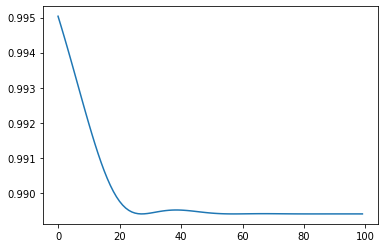

In [21]:
def train(x, model):
    opt = torch.optim.Adam(params=[x] + list(model.parameters()), lr=0.01)
    
    loss_trace = []
    for i in trange(100): # MORE EPOCHS
        opt.zero_grad()
        
        cln_out = model(x)
        loss = 1 - cln_out
        
        loss_trace.append(loss.item())

        loss.backward()
        opt.step()
                
    return pd.DataFrame({'loss':loss_trace})

x = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)
t = train(x, model)
plt.plot(t.loss)


Check model results:

In [22]:
x[0].item()

0.25108155608177185

In [23]:
s = z3.Solver()
s.from_file(smtlib_problems[0])

skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
skoZ = z3.Real('skoZ')
s.add(skoX == x[0].item() and skoY == x[1].item() and skoZ == x[2].item())

In [24]:
s

[And(Not(1 + skoX*-1 + skoY*-1 <= skoZ),
     And(Not(skoZ <= 0),
         And(Not(skoY <= 0), Not(skoX <= 0)))),
 skoX == 5021631121635437/20000000000000000]

In [25]:
s.check()

sat

In [26]:
s.model()

[skoX = 5021631121635437/20000000000000000,
 skoZ = 4992789626121521/20000000000000000,
 skoY = 4992789626121521/20000000000000000]

## Solving from random initialization:
Can we learn from random start?


In [30]:
x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)
x

tensor([-5.2681,  1.7614, -2.8222], dtype=torch.float64, requires_grad=True)

In [31]:
model = CLNModel(B=3)

print('x before', x, '\nloss before', 1-model(x))
trace = train(x, model)
print('\nx after', x, '\nloss after', 1-model(x))

100%|██████████| 100/100 [00:00<00:00, 837.37it/s]

x before tensor([-5.2681,  1.7614, -2.8222], dtype=torch.float64, requires_grad=True) 
loss before tensor(1.0000, dtype=torch.float64, grad_fn=<RsubBackward1>)

x after tensor([-5.2677,  1.7614, -2.8218], dtype=torch.float64, requires_grad=True) 
loss after tensor(1.0000, dtype=torch.float64, grad_fn=<RsubBackward1>)


In [32]:
s = z3.Solver()
s.from_file(smtlib_problems[0])
skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
skoZ = z3.Real('skoZ')
s.add(skoX == x[0].item() and skoY == x[1].item() and skoZ == x[2].item())
s.check()

unsat

Clearly does not work reliably... can we do better?
- increase learning rate
- add decay
- make B parameter
- go for more epochs

In [33]:
def improved_train(x, model):
    opt = torch.optim.Adam(params=[x] + list(model.parameters()), lr=0.25)
    
    # LR DECAY
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opt, lambda epoch: 0.99)
    
    loss_trace = []
    for i in trange(500): # MORE EPOCHS
        opt.zero_grad()
        
        cln_out = model(x)
        loss = 1 - cln_out
        
        loss_trace.append(loss.item())

        loss.backward()
        opt.step()
        scheduler.step()
                
    return pd.DataFrame({'loss':loss_trace})

In [34]:
x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)


B_param = torch.nn.Parameter(torch.tensor(1.0))


model = CLNModel(B=B_param)

print('x before', x, '\nloss before', 1-model(x))
trace = improved_train(x, model)
print('\nx after', x, '\nloss after', 1-model(x))

 35%|███▌      | 177/500 [00:00<00:00, 867.36it/s]

x before tensor([-9.2767, -7.3041,  6.8930], dtype=torch.float64, requires_grad=True) 
loss before tensor(1.0000, dtype=torch.float64, grad_fn=<RsubBackward1>)


100%|██████████| 500/500 [00:00<00:00, 887.63it/s]


x after tensor([0.2500, 0.2500, 0.2500], dtype=torch.float64, requires_grad=True) 
loss after tensor(0.3156, dtype=torch.float64, grad_fn=<RsubBackward1>)


check if solving reliably...

In [35]:
s = z3.Solver()
s.from_file(smtlib_problems[0])
skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
skoZ = z3.Real('skoZ')
s.add(skoX == x[0].item() and skoY == x[1].item() and skoZ == x[2].item())
s.check()

sat

See if you can solve problems 1-3!

In [36]:
smtlib_problems

['../data/smtlib_problems/cbrt-problem-3-chunk-0035.smt2',
 '../data/smtlib_problems/cbrt-problem-3-chunk-0043.smt2',
 '../data/smtlib_problems/cbrt-problem-3-chunk-0071.smt2',
 '../data/smtlib_problems/cbrt-problem-3-chunk-0074.smt2']